In [217]:
import time

import h5py
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import random

# sklearn
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

import pywt

In [2]:
train_file = h5py.File('data/X_train.h5', 'r')
test_file = h5py.File('data/X_test.h5', 'r')
train_class = pd.read_csv('data/y_train.csv')
train_class.head()

,index,sleep_stage
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


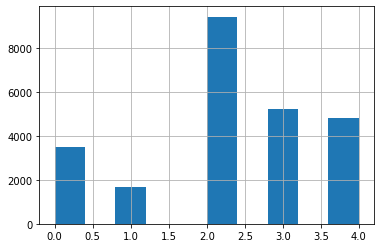

In [3]:
train_class.sleep_stage.hist()
plt.show()

In [4]:
eegs = np.stack([train_file[f"eeg_{i}"]for i in range(1,8)], axis=1)
acc = np.stack([train_file[key] for key in ["x", "y", "z"]], axis=1)
y = np.array(train_class.sleep_stage)

print(eegs.shape)
print(acc.shape)

(24688, 7, 1500)
(24688, 3, 300)


In [ ]:
test_eegs = np.stack([test_file[f"eeg_{i}"]for i in range(1,8)], axis=1)
test_acc = np.stack([test_file[key] for key in ["x", "y", "z"]], axis=1)

print(test_eegs.shape)
print(test_acc.shape)

## Generating bands

In [5]:
eeg_subbands = pywt.wavedec(eegs, 'db2', level=4)
pulse_subbands = pywt.wavedec(train_file["pulse"], 'db2', level=4)
acc_subbands = pywt.wavedec(acc, 'db2', level=4)

In [ ]:
test_eeg_subbands = pywt.wavedec(test_eegs, 'db2', level=4)
test_pulse_subbands = pywt.wavedec(test_file["pulse"], 'db2', level=4)
test_acc_subbands = pywt.wavedec(test_acc, 'db2', level=4)

In [6]:
def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    LABEL_NAMES = [0,1,2,3,4]
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()


In [188]:
def feature_extractor(eegs, acc, pulse):

    X = np.ndarray(shape=(eegs.shape[0],1))
    
    # Mean
    X = np.concatenate([X, np.mean(eegs, axis=-1)], axis=-1)
    X = np.concatenate([X, np.expand_dims(np.mean(pulse, axis=-1), axis=-1)], axis=-1)
    X = np.concatenate([X, np.mean(acc, axis=-1)], axis=-1) 

    # Median
    X = np.concatenate([X, np.median(eegs, axis=-1)], axis=-1)
    X = np.concatenate([X, np.expand_dims(np.median(pulse, axis=-1), axis=-1)], axis=-1)
    X = np.concatenate([X, np.median(acc, axis=-1)], axis=-1)
    
    # Standard deviation
    X = np.concatenate([X, np.std(eegs, axis=-1)], axis=-1)
    X = np.concatenate([X, np.expand_dims(np.std(pulse, axis=-1), axis=-1)], axis=-1)
    X = np.concatenate([X, np.std(acc, axis=-1)], axis=-1)
    
    # Mode
    X = np.concatenate([X, stats.mode(eegs, axis=2).mode.squeeze(-1)], axis=-1)
    X = np.concatenate([X, stats.mode(pulse, axis=1).mode], axis=-1)
    X = np.concatenate([X, stats.mode(acc, axis=2).mode.squeeze(-1)], axis=-1)
    
    # Skewness
    X = np.concatenate([X, stats.skew(eegs, axis=2)], axis=-1)
    X = np.concatenate([X, np.expand_dims(stats.skew(pulse, axis=1), axis=-1)], axis=-1)
    X = np.concatenate([X, stats.skew(acc, axis=2)], axis=-1)
    
    # Kurtosis
    X = np.concatenate([X, stats.kurtosis(eegs, axis=2)], axis=-1)
    X = np.concatenate([X, np.expand_dims(stats.kurtosis(pulse, axis=1), axis=-1)], axis=-1)
    X = np.concatenate([X, stats.kurtosis(acc, axis=2)], axis=-1)
    
#     # Maximum
#     X = np.concatenate([X, np.max(eegs, axis=-1)], axis=-1)
#     X = np.concatenate([X, np.expand_dims(np.max(pulse, axis=-1), axis=-1)], axis=-1)
#     X = np.concatenate([X, np.max(acc, axis=-1)], axis=-1)
    
#     # Minimum
#     X = np.concatenate([X, np.min(eegs, axis=-1)], axis=-1)
#     X = np.concatenate([X, np.expand_dims(np.min(pulse, axis=-1), axis=-1)], axis=-1)
#     X = np.concatenate([X, np.min(acc, axis=-1)], axis=-1)
    
    return X[:,1:]

In [189]:
features = []
for i in range(5):
    features.append(feature_extractor(eeg_subbands[i], acc_subbands[i], pulse_subbands[i]))
features.append(feature_extractor(eegs, acc, train_file["pulse"]))

In [190]:
X = np.concatenate(features, axis=-1)

In [207]:
cv = 8
kf = StratifiedKFold(n_splits=cv, shuffle=True)
accuracies = []
f1_scores = []
for train_index, val_index in tqdm(kf.split(X, y)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracies.append(accuracy_score(y_pred, y_val))
    f1_scores.append(f1_score(y_pred, y_val, average='weighted'))

<ipython-input-207-556c620a0c5a>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for train_index, val_index in tqdm(kf.split(X, y)):


|          | 0/? [00:00<?, ?it/s]

C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:46:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [208]:
print(f"Average accuracy : {np.mean(accuracies)} (+-) {np.std(accuracies)}")
print(f"Average f1-score : {np.mean(f1_scores)} (+-) {np.std(f1_scores)}")

Average accuracy : 0.8152948801036941 (+-) 0.005575064981881173
Average f1-score : 0.8261532127648681 (+-) 0.004963562453063285


# Submission time

In [225]:
clf = make_pipeline(StandardScaler(), XGBClassifier(max_depth=10))
clf.fit(X, y)

C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

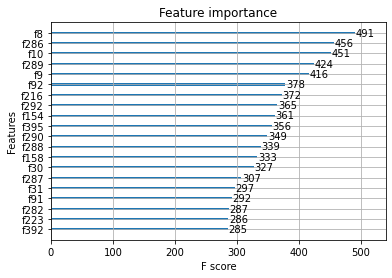

In [233]:
plot_importance(clf[1], max_num_features=20) # top 10 most important features
plt.show()

In [226]:
test_features = []
for i in tqdm(range(5)):
    test_features.append(feature_extractor(test_eeg_subbands[i], test_acc_subbands[i], test_pulse_subbands[i]))
test_features.append(feature_extractor(test_eegs, test_acc, test_file["pulse"]))

X_test = np.concatenate(test_features, axis=-1)

<ipython-input-226-857c9a84840b>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

In [227]:
y_test = np.expand_dims(clf.predict(X_test), axis=-1)

In [228]:
index = np.expand_dims(np.arange(24688, 24688+y_test.shape[0]), axis=-1)

In [229]:
df = pd.DataFrame(np.concatenate([index, y_test],axis=-1), columns=['index', 'sleep_stage'])
df.reset_index(drop=True, inplace=True)

In [230]:
df.to_csv("submission.csv")